$\mathbf{OMARI}$ $\mathbf{Tarek}$ 

$\mathbf{Objtectif}$ : Enrechissment des EI avec le modème PESHMELBA

Dans le travail précédent nous avons essayer de trouver le minmum en utilisant les BO sans enrichir la fonction d'acquisition 'EI', C'est à dire, nous avons évalué le point proposé par les 'EI' (le point maximum) avec la fonction gaussienne (gp.predict()) ajusté sur les 50 observations que nous avons. Ce qui a donnée un résultat non précis avec une grande incertitude. Ainsi, le but de ce chapitre c'est d'évaluer le point proposé avec vraie fonction (PESHMELBA) et réajuster les GP avec une nouvelle observation obtenue pour améaliorer la pérformance de l'optimisation et trouver le vrai optimum. Enfin, noous comparons le point optimal treouvé x_optimal avec le x_true afin de voir la qualité de calibration de nos paramètres du sol. 

**EI sur une fonction simple en considérant qu'on la connait pas ( boîte noire), CODE MODElE**

**TOY function, My example**

In [108]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt

from skopt import gp_minimize
from skopt.space import Real
from skopt.plots import plot_gaussian_process
np.random.seed(42)

# Define the search space
noise_level = 0

def f(x):
    return (x[0]) ** 2 

space = [(-4.0, 4.0)]

# Initial evaluation points
x_initial = [[2], [4], [-2]]
# Evaluate the objective function at initial points
f_initial = [f(x) for x in x_initial]


# Run gp_minimize
res_great = gp_minimize(f,                  # the function to minimize
                        space,              # the bounds on each dimension of x
                        noise=0,            # noise level
                        acq_func="EI",      # the acquisition function
                        n_calls=1,         # the number of evaluations
                        x0=x_initial,       # Specify initial points
                        y0=f_initial,       # Specify initial function values
                        n_initial_points=0, # Specify initial evaluations
                        n_random_starts=0,
                        random_state=42)

# Extract the final minimum p'gaussian'
min_x = res_great.x_iters[-1]
min_y = res_great.fun
print(min_x)
print(min_y)
#plt.rcParams["figure.figsize"] = (14, 6)

# Plot f(x) + contours
#_ = plot_gaussian_process(res_great, objective=f,
                         #noise_level=noise_level,show_next_point=True, show_observations=True, show_acq_func= True)
# Add a vertical line at the next point
#plt.axvline([1.2540234318908006], color='blue', linewidth=0.7, linestyle='--', label='Next Point')
#plt.axvline([0], color='orange', linewidth=0.7, linestyle='--', label='True minmum')

# Optionally, add a legend
#plt.legend()

#plt.show()
#print(res_great.x_iters[-1])
#print(res_great.x) 
#print(res_great)
#print(f_initial)


[1.924532998096769]
3.703827260763338


**EI Maxmization, Another method**

In [18]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from scipy.stats import norm

np.random.seed(42)

# Define the search space
noise_level = 0

def f(x):
    return x ** 2 

bounds = [(-6.0, 6.0)]

# Initial evaluation points
x_initial = np.array([[2], [4], [-2], [1], [-4]])  # Convert to 2D array

# Evaluate the objective function at initial points
f_initial = [f(x[0]) for x in x_initial]

# Gaussian Process
kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the model
gp.fit(x_initial, f_initial)

# Define the Expected Improvement function
def ei(x):
    x = np.atleast_2d(x).reshape(-1, 1)
    mean, std = gp.predict(x, return_std=True)
    z = (min(f_initial) - mean) / std
    return - std * (z * norm.cdf(z) + norm.pdf(z))

# Perform the optimization
result = differential_evolution(func=ei, bounds=bounds, strategy='best1bin', init=x_initial)

print("Optimal point:", result.x)


Optimal point: [0.01777594]


**EI(x), Finding the best next guess for only one rain**

In [8]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from skopt import gp_minimize
from skopt.space import Real
#import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import csv 
import os  
import sys 

# Load the provided data files

x_train_path = '/home/tomari/Documents/First_simulation/x_train_trial.csv'
x_true_path  = '/home/tomari/Documents/First_simulation/x_true.csv'
y_obs_path   = '/home/tomari/Documents/First_simulation/y_obs_trial.csv'
y_train_path = '/home/tomari/Documents/First_simulation/y_train_trial.csv'
x_train_perc_path = '/home/tomari/Documents/First_simulation/x_traine.csv'

# Load the data from the provided CSV files
x_train_df = pd.read_csv(x_train_path)
y_train_df = pd.read_csv(y_train_path)
y_obs_df = pd.read_csv(y_obs_path)
x_train_perc_df = pd.read_csv(x_train_perc_path)

# clean data 

x_train_cl = x_train_df.drop(x_train_df.columns[0], axis=1)

x_train_perc_cl =  x_train_perc_df.drop(x_train_perc_df.columns[0], axis=1)

#y_train_cl = y_train_df.drop(y_train_df.columns[0], axis=1)

#y_obs_cl = y_obs_df.drop(y_obs_df.columns[0], axis=1)

# Convert DataFrames to numpy arrays
y_train = y_train_df.values

y_obs = y_obs_df.values

x_train = x_train_cl.values

x_train_perc = x_train_perc_cl.values
#Conversion of x_train to a list 

x_train_list_old = x_train.tolist() 

# Assuming x_train is a NumPy array with shape (50, 6)
x_train_list = x_train.tolist()

# Compute MSE for each block
# Listing the data for two paramters only for regularization

x_train_mn = x_train[:,1]

x_train_tr = x_train[:,4]

def cost(y_train):
    
   # Initialize an array to store the MSE for each block
   cost_on_one_rain = np.zeros((len(x_train)))
  
   for i in range(len(x_train)):
         
        # Compute the MSE between the block and the corresponding observation
        F = (
        np.sum((y_train[i] - y_obs)**2) +
        6e-3*np.sum(((x_train_mn[i] - 0.1791) / 0.0179)**2) +
        6e-4*np.sum(((x_train_tr[i] - 0.0612) / 0.0153)**2)
        )
                
        # Store the MSE in the appropriate index of the global_costs_on_rains array
       
        cost_on_one_rain[i] = F
        
   return cost_on_one_rain
    
# the evaluations of the cost function on 50 parameter set 

f_values = cost(y_train)

#Conversion to a list 

f_values_list = f_values.tolist() 

def f_2(x):
  return x[0]**2
    
#Create space with percentiles 
lower_bound = np.zeros(len(x_train[1,:]))
upper_bound = np.zeros(len(x_train[1,:]))
space = []

for i in range(len(x_train[1,:])):
    lower_bound[i] =  np.percentile(x_train[:,i], 0)
    upper_bound[i] =  np.percentile(x_train[:,i], 100)
    space.append(Real(lower_bound[i], upper_bound[i]))

#defining our search space with min max boundaries

#parame_names = x_train_cl.columns.tolist() # lisiting the paramters names in our data frame 

#space = [Real(x_train_cl[col].min(), x_train_cl[col].max(), name=col) for col in parame_names] # defining the search space for each paramters based on boundaries 

# Optimisation process 
results_EI_z1 = gp_minimize(f_2,
                      space,
                      noise = 0,
                      n_calls = 1,
                      x0=x_train_list,
                      y0=f_values_list,
                      n_initial_points=0,
                      acq_func = 'EI',
                      random_state=1234) 
x_new = results_EI_z1.x_iters[-1]

print("x_n+1 = Argmax EI(x) = ", x_new)

# Paramter names 

parameter_names = ["thetas_9","mn_10", "thetas_10", "thetas_13","thetar_10","hg_10"]

# Append x_new to x_train

x_new_reshaped = [x_new]

#
x_new_df= pd.DataFrame(x_new_reshaped, columns = parameter_names)

# Concatenate x_train_df and x_new_df

x_train_cl = pd.concat([x_train_cl, x_new_df], ignore_index=True)

#print(x_train_df)

# Specify the file name

xnext_csv = (f"x_new_1.csv")


# Specify the directory path

directory = '/home/tomari/Documents/First_simulation/'

# Specify the file name with its source (directory) 

xnext_csv = os.path.join(directory, f"x_new_1.csv")

#output_csv_path = f'/home/tomari/Documents/First_simulation/x_train_trial.csv'

# Save the DataFrame as a CSV file
#x_train_cl.index = x_train_cl.index + 1

#x_train_cl.to_csv(output_csv_path, index=True)


# Write the list of float values to a CSV file
with open(xnext_csv, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['', 'x'])
    for parameter_names, value in zip(parameter_names, x_new):
        writer.writerow([parameter_names,value])
  
#print(results_EI_z1) 

print(f"CSV file '{xnext_csv}' has been created successfully.")
#print("DataFrame saved as CSV file:", output_csv_path)


x_n+1 = Argmax EI(x) =  [0.2502640182095988, 0.1644580740542722, 0.374247506928565, 0.279840011079228, 0.0912941407765363, -2.81895948290551]
CSV file '/home/tomari/Documents/First_simulation/x_new_1.csv' has been created successfully.


In [11]:

param_dist = [
    (x_train_df.columns[0], 0.3322, 0.03322),
    (x_train_df.columns[1], 0.1791, 0.0179),
    (x_train_df.columns[2], 0.316, 0.0316),
    (x_train_df.columns[3], 0.3375, 0.0338),
    (x_train_df.columns[4], 0.0612, 0.0153),
    (x_train_df.columns[5],-3.560000, 0.35600000)
]
lower_bound = np.zeros(len(param_dist))
upper_bound = np.zeros(len(param_dist))
space = []

for i in range(len(param_dist)):
 lower_bound[i] =  stats.norm.ppf(0.0001, loc=param_dist[i][1], scale=param_dist[i][2])
 upper_bound[i] =  stats.norm.ppf(0.999, loc=param_dist[i][1], scale=param_dist[i][2])
 space.append(Real(lower_bound[i], upper_bound[i]))
# Calculate percentiles for each parameter
# Print or use the space as needed
#print(space)
# Given list
np.shape(x_train)
#print(x_train_list)
print(space)

#maze = [Real(-1.0, 1.0)]
#print(maze)

# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from skopt import gp_minimize
from skopt.space import Real
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import csv
import os
import sys
import configparser

# Get the SLURM array task ID from command line arguments
j = int(sys.argv[1])

# Load the provided data files
x_true_path = '/lustre/omarit/EGO_FRAMEWORK/OUTPUT/x_true.csv'

x_train_perc_path =  '/lustre/omarit/EGO_FRAMEWORK/OUTPUT/x_traine.csv'

# Définissez votre chemin d'accès au dossier contenant vos fichiers CSV
Calibration_data_path = "/lustre/omarit/EGO_FRAMEWORK/OUTPUT"

# Générez les noms de fichiers pour x_train et y_train
x_train_file = f"x_train{j}.csv"
y_train_file = f"y_train{j}.csv"
y_obs_file = f"y_obs{j}.csv"
# Chemins complets des fichiers

x_train_path = os.path.join(Calibration_data_path , x_train_file)
y_train_path = os.path.join(Calibration_data_path , y_train_file)
y_obs_path =  os.path.join(Calibration_data_path , y_obs_file)


# Load the data from the provided CSV files
x_train_df = pd.read_csv(x_train_path)
y_train_df = pd.read_csv(y_train_path)
y_obs_df = pd.read_csv(y_obs_path)
x_train_perc_df = pd.read_csv(x_train_perc_path)


# clean data 

x_train_cl = x_train_df.drop(x_train_df.columns[0], axis=1)

x_train_perc_cl =  x_train_perc_df.drop(x_train_perc_df.columns[0], axis=1)
#y_train_cl = y_train_df.drop(y_train_df.columns[0], axis=1)

#y_obs_cl = y_obs_df.drop(y_obs_df.columns[0], axis=1)

# Convert DataFrames to numpy arrays
y_train = y_train_df.values

y_obs = y_obs_df.values

x_train = x_train_cl.values

x_train_perc = x_train_perc_cl.values


#Conversion of x_train to a list 

x_train_list_old = x_train.tolist()

# Assuming x_train is a NumPy array with shape (50, 6)
x_train_list = x_train.tolist()

#Conditioning the update of y_train and x_train in case of bugging 

if len(x_train) == len(y_train): 
    
    # Compute MSE for each block
    
    def cost(y_train):
    
       # Initialize an array to store the MSE for each block
       cost_rains = np.zeros((len(x_train)))
    
       for i in range(len(y_train)):
    
            # Compute the MSE between the block and the corresponding observation
            F = np.sum((y_train[i] - y_obs)**2)
    
            # Store the MSE in the appropriate index of the global_costs_on_rains array
            cost_rains[i] = F
    
       return cost_rains
    
    # the evaluations of the cost function on 50 parameter set 
    
    f_values = cost(y_train)
    
    #Conversion to a list 
    
    f_values_list = f_values.tolist()
    
    print(f"the minimum is :{f_values_list[-1]}")
    def f_2(x):
      return x[0]**2
    
    #print(f_values_z1_list)
    
    #Create space based on  percentiles 
    
    lower_bound = np.zeros(len(x_train[1,:]))
    upper_bound = np.zeros(len(x_train[1,:]))
    space = []
    
    for i in range(len(x_train[1,:])):
     lower_bound[i] =  np.percentile(x_train[:,i], 0)
     upper_bound[i] =  np.percentile(x_train[:,i], 100)
    space.append(Real(lower_bound[i], upper_bound[i], transform='normalize'))
    
    # defining our search space with min max boundaries
    
    #parame_names = x_train_cl.columns.tolist() # lisiting the paramters names in our data frame 
    
    #space = [Real(x_train_cl[col].min(), x_train_cl[col].max(), name=col) for col in parame_names] # defining the search space for each paramters based on boundaries 
    
    
    # Optimisation process 
    results_EI_z1 = gp_minimize(f_2,
                          space,
                          noise=0,
                          n_calls = 1,
                          x0=x_train_list,
                          y0=f_values_list,
                          n_initial_points=0,
                          acq_func = 'EI',
                          random_state=1234)
    x_new = results_EI_z1.x_iters[-1]
    
    print("x_n+1 = Argmax EI(x) = ", x_new)
    
    # Paramter names 
    
    
    paramter_names = ["thetas_9","mn_10", "thetas_10", "thetas_13","thetar_10","hg_10"]
    
    # Append x_new to x_train
    
    x_new_reshaped = [x_new]
    
    # Convert x_new to a data frame to work out the appendix with x_train_cl
    
    x_new_df= pd.DataFrame(x_new_reshaped, columns = paramter_names)
    
    # Concatenate x_train_df and x_new_df
    
    x_train_cl = pd.concat([x_train_cl, x_new_df], ignore_index=True)
    
    xnext_csv = f"x_new{j}.csv"
    
    
    # Specify the directory path
    
    directory = '/lustre/omarit/EGO_FRAMEWORK/OUTPUT'
    
    # Specify the file name
    
    xnext_csv = os.path.join(directory, f"x_new{j}.csv")
    
    # specify the path where the updated (appended) x_train is saved
    
    output_csv_path = f"/lustre/omarit/EGO_FRAMEWORK/OUTPUT/x_train{j}.csv"
    
    # Adjust the index start from 0 to 1 
    
    x_train_cl.index = x_train_cl.index + 1
    
    # Save the DataFrame as a CSV file
    
    x_train_cl.to_csv(output_csv_path, index=True)
    
    
    # Write the list of float values to a CSV file
    with open(xnext_csv, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['', 'x'])
        for paramter_names, value in zip(paramter_names, x_new):
            writer.writerow([paramter_names,value])
    
    #print(results_EI_z1) 
    print(f"CSV file '{xnext_csv}' has been created successfully.")
    print("DataFrame saved as CSV file:", output_csv_path)
else:

    print(f"updating x_train{j} and y_train{j} for this step is denied, no EI's enrichment for this iteration !") 

ValueError: invalid literal for int() with base 10: '-f'

**Code Optimisation pour la parallélisation**

In [35]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from skopt import gp_minimize
from skopt.space import Real
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import csv 
import os  

j = '_trial'
# Load the provided data files
x_true_path = '/home/tomari/Documents/First_simulation/x_true.csv'

# Définissez votre chemin d'accès au dossier contenant vos fichiers CSV
Calibration_data_path = "/home/tomari/Documents/First_simulation"

# Générez les noms de fichiers pour x_train et y_train
x_train_file = f"x_train{j}.csv"
y_train_file = f"y_train{j}.csv"
y_obs_file = f"y_obs{j}.csv"

# Chemins complets des fichiers

x_train_path = os.path.join(Calibration_data_path , x_train_file)
y_train_path = os.path.join(Calibration_data_path , y_train_file)
y_obs_path =  os.path.join(Calibration_data_path , y_obs_file)


# Load the data from the provided CSV files
x_train_df = pd.read_csv(x_train_path)
y_train_df = pd.read_csv(y_train_path)
y_obs_df = pd.read_csv(y_obs_path)


#Clean the data

if len(x_train_df) == len(y_train_df):
    
    x_train_cl = x_train_df.drop(x_train_df.columns[0], axis=1)
    
elif len(x_train_df) > len(y_train_df):
    
    x_train_cl = x_train_df.drop(x_train_df.columns[0], axis=1).iloc[:-1]
   
#y_train_cl = y_train_df.drop(y_train_df.columns[0], axis=1)

#y_obs_cl = y_obs_df.drop(y_obs_df.columns[0], axis=1)

# Convert DataFrames to numpy arrays

y_train = y_train_df.values

y_obs = y_obs_df.values 

x_train = x_train_cl.values

#Conversion of x_train to a list 

x_train_list_old = x_train.tolist() 

# Assuming x_train is a NumPy array with shape (50, 6)
x_train_list = x_train.tolist()

# Compute MSE for each block

def cost(y_train):
    
   # Initialize an array to store the MSE for each block
   cost_on_one_rain = np.zeros((len(x_train)))
  
   for i in range(len(y_train)):
         
        # Compute the MSE between the block and the corresponding observation
        F = np.sum((y_train[i] - y_obs)**2)
        
        # Store the MSE in the appropriate index of the global_costs_on_rains array
        cost_on_one_rain[i] = F
        
   return cost_on_one_rain
    
# the evaluations of the cost function on 50 parameter set 

f_values = cost(y_train)

#Conversion to a list 

f_values_list = f_values.tolist() 

def f_2(x):
  return x[0]**2

#print(f_values_z1_list)

# defining our search space 
#Create space based on  percentiles 

lower_bound = np.zeros(len(x_train[1,:]))
upper_bound = np.zeros(len(x_train[1,:]))
space = []

for i in range(len(x_train[1,:])):
 lower_bound[i] =  np.percentile(x_train[:,i], 0)
 upper_bound[i] =  np.percentile(x_train[:,i], 100)
 space.append(Real(lower_bound[i], upper_bound[i], transform='normalize'))

# Optimisation process 
results_EI_z1 = gp_minimize(f_2,
                      space, 
                      noise = 0, 
                      n_calls = 1,
                      x0=x_train_list,
                      y0=f_values_list,
                      n_initial_points=0,
                      acq_func = 'EI',
                      random_state=1234) 
x_new = results_EI_z1.x_iters[-1]

print("x_n+1 = Argmax EI(x) = ", x_new)

# Paramter names 

paramter_names = ["thetas_9","mn_10", "thetas_10", "thetas_13","thetar_10","hg_10"]

# Append x_new to x_train

x_new_reshaped = [x_new]



if len(x_train_df) >= len(y_train_df):

    # Convert x_new to a data frame to work out the appendix with x_train_cl

    x_new_df= pd.DataFrame(x_new_reshaped, columns = paramter_names)

    # Concatenate x_train_df and x_new_df

    x_train_cl = pd.concat([x_train_cl, x_new_df], ignore_index=True)

    # specify the path where the updated (appended) x_train is saved

    output_csv_path = f"/home/tomari/Documents/First_simulation/x_train{j}.csv"

    # Adjust the index start from 0 to 1 

    x_train_cl.index = x_train_cl.index + 1

    # Save the DataFrame as a CSV file

    x_train_cl.to_csv(output_csv_path, index=True)
    

#else: 
    
#    print(f"updating x_train{j} and y_train{j} for this step is denied, no EI's enrichment for this iteration !") 

# Specify the file name

xnext_csv = f"x_new{j}.csv"

# Specify the directory path

directory = '/home/tomari/Documents/First_simulation'

# Specify the file name for x_new 

xnext_csv = os.path.join(directory, f"x_new{j}.csv")

# Write the list of float values to a CSV file
with open(xnext_csv, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['', 'x'])
    for paramter_names, value in zip(paramter_names, x_new):
        writer.writerow([paramter_names,value])
        
#print(results_EI_z1) 
print(f"CSV file '{xnext_csv}' has been created successfully.")
print(len(x_train_cl))

x_n+1 = Argmax EI(x) =  [0.3044074005480982, 0.147173088307039, 0.3391580007792669, 0.279840011079228, 0.0912941407765363, -4.47128214665854]
CSV file '/home/tomari/Documents/First_simulation/x_new_trial.csv' has been created successfully.
26


**Percintiles Trials**

In [27]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from skopt import gp_minimize
from skopt.space import Real
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import csv 
import os  
import sys 

# Load the provided data files

x_train_path = '/home/tomari/Documents/First_simulation/x_train_trial.csv'
x_true_path  = '/home/tomari/Documents/First_simulation/x_true.csv'
y_obs_path   = '/home/tomari/Documents/First_simulation/y_obs_trial.csv'
y_train_path = '/home/tomari/Documents/First_simulation/y_train_trial.csv'
x_train_perc_path =  '/home/tomari/Documents/First_simulation/x_train.csv'

# Load the data from the provided CSV files
x_train_df = pd.read_csv(x_train_path)
y_train_df = pd.read_csv(y_train_path)
y_obs_df = pd.read_csv(y_obs_path)
x_train_perc_df = pd.read_csv(x_train_perc_path)

# clean data 

x_train_cl = x_train_df.drop(x_train_df.columns[0], axis=1)

x_train_perc_cl =  x_train_perc_df.drop(x_train_perc_df.columns[0], axis=1)
#y_train_cl = y_train_df.drop(y_train_df.columns[0], axis=1)

#y_obs_cl = y_obs_df.drop(y_obs_df.columns[0], axis=1)

# Convert DataFrames to numpy arrays
y_train = y_train_df.values

y_obs = y_obs_df.values

x_train = x_train_cl.values

x_train_perc = x_train_perc_cl.values
#Conversion of x_train to a list 

x_train_list_old = x_train.tolist() 

# Assuming x_train is a NumPy array with shape (50, 6)
x_train_list = x_train.tolist()

# Compute MSE for each block

def cost(y_train):
    
   # Initialize an array to store the MSE for each block
   cost_on_one_rain = np.zeros((len(x_train)))
  
   for i in range(len(y_train)):
         
        # Compute the MSE between the block and the corresponding observation
        F = ((y_train[i] - y_obs)**2).mean()
        
        # Store the MSE in the appropriate index of the global_costs_on_rains array
        cost_on_one_rain[i] = F
        
   return cost_on_one_rain
    
# the evaluations of the cost function on 50 parameter set 

f_values = cost(y_train)

#Conversion to a list 

f_values_list = f_values.tolist() 

def f_2(x):
  return x[0]**2

#print(f_values_z1_list)

lower_bound = np.zeros(len(x_train[1,:]))
upper_bound = np.zeros(len(x_train[1,:]))
space = []

for i in range(len(x_train[1,:])):
 lower_bound[i] =  np.percentile(x_train_perc[:,i], 0)
 upper_bound[i] =  np.percentile(x_train_perc[:,i], 100)
 space.append((lower_bound[i], upper_bound[i]))

# Sample data
#data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Calculating extreme percentiles
#p0_1 = np.percentile(data, 0.1)  # 0.1st percentile
#p99_9 = np.percentile(data, 99.9)  # 99.9th percentile


# Optimisation process 
results_EI_z1 = gp_minimize(f_2,
                      space, 
                      n_calls = 1,
                      x0=x_train_list,
                      y0=f_values_list,
                      n_initial_points=0,
                      acq_func = 'EI',
                      random_state=1234) 
x_new = results_EI_z1.x_iters[-1]

print("x_n+1 = Argmax EI(x) = ", x_new)

# Paramter names 

parameter_names = ["thetas_9","mn_10", "thetas_10", "thetas_13","thetar_10","hg_10"]

# Append x_new to x_train

x_new_reshaped = [x_new]

#
x_new_df= pd.DataFrame(x_new_reshaped, columns = parameter_names)

# Concatenate x_train_df and x_new_df

x_train_cl = pd.concat([x_train_cl, x_new_df], ignore_index=True)

#print(x_train_df)

# Specify the file name

xnext_csv = (f"x_new.csv")


# Specify the directory path

directory = '/home/tomari/Documents/First_simulation/'

# Specify the file name with its source (directory) 

xnext_csv = os.path.join(directory, f"x_new.csv")

#output_csv_path = f'/home/tomari/Documents/First_simulation/x_train_trial.csv'

# Save the DataFrame as a CSV file
x_train_cl.index = x_train_cl.index + 1

#x_train_cl.to_csv(output_csv_path, index=True)


# Write the list of float values to a CSV file
with open(xnext_csv, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['', 'x'])
    for parameter_names, value in zip(parameter_names, x_new):
        writer.writerow([parameter_names,value])
  
#print(results_EI_z1) 

print(f"CSV file '{xnext_csv}' has been created successfully.")
#print("DataFrame saved as CSV file:", output_csv_path)

FileNotFoundError: [Errno 2] No such file or directory: '/home/tomari/Documents/First_simulation/x_train.csv'

In [10]:
np.shape(x_train[:,1])
x_train[:,5]
print(space)

[(0.231736190325398, 0.400385419751111), (0.136934471370884, 0.217771692107196), (0.239802826397668, 0.383150173195185), (0.256109065758646, 0.426909941304935), (0.0218417050428458, 0.0912941407765363), (-4.47128214665854, -2.81895948290551)]


**The Minimum point of the Calibration cost function**


In [11]:
import numpy as np
import pandas as pd
# Load the provided data files
x_train_path = '/home/tomari/Documents/First_simulation/x_train_B25.csv'
x_true_path = '/home/tomari/Documents/First_simulation/x_true.csv'
y_obs_path = '/home/tomari/Documents/First_simulation/y_obs_z1.csv'
y_train_path = '/home/tomari/Documents/First_simulation/y_train_z1_B25.csv'

# Load the data from the provided CSV files
x_train_df = pd.read_csv(x_train_path)
y_train_df = pd.read_csv(y_train_path)
y_obs_df = pd.read_csv(y_obs_path)

# Convert DataFrames to numpy arrays
y_train = y_train_df.values

y_obs = y_obs_df.values 

x_train = x_train_df.values

x_calb = x_train_df.min()

print(x_calb)
print(f_values 

      # Paramter names 


paramter_names = ["thetas_9","mn_10", "thetas_10", "thetas_13","thetar_10","hg_10"]

# Append x_new to x_train

x_new_reshaped = [x_new]

#
x_new_df= pd.DataFrame(x_new_reshaped, columns = paramter_names)

# Concatenate x_train_df and x_new_df
x_train_df = pd.concat([x_train_df, x_new_df], ignore_index=True)

#print(x_train_df)
# Specify the file name

xnew_csv = 'x_new.csv'

# for x_train 
xtrain_csv = 'x_train_B25.csv'

# Specify the directory path
directory = '/home/tomari/Documents/First_simulation'

# Specify the file name
xnew_csv = os.path.join(directory, 'x_new.csv')

output_csv_path = '/home/tomari/Documents/First_simulation/x_train_B25.csv'

# Save the DataFrame as a CSV file
x_train_df.to_csv(output_csv_path, index=False)


# Write the list of float values to a CSV file
with open(xnew_csv, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['', 'x'])
    for paramter_names, value in zip(paramter_names, x_new):
        writer.writerow([paramter_names,value])

#print(results_EI_z1) 
print(f"CSV file '{xnew_csv}' has been created successfully.")
print("DataFrame saved as CSV file:", output_csv_path)

SyntaxError: '(' was never closed (826688093.py, line 24)

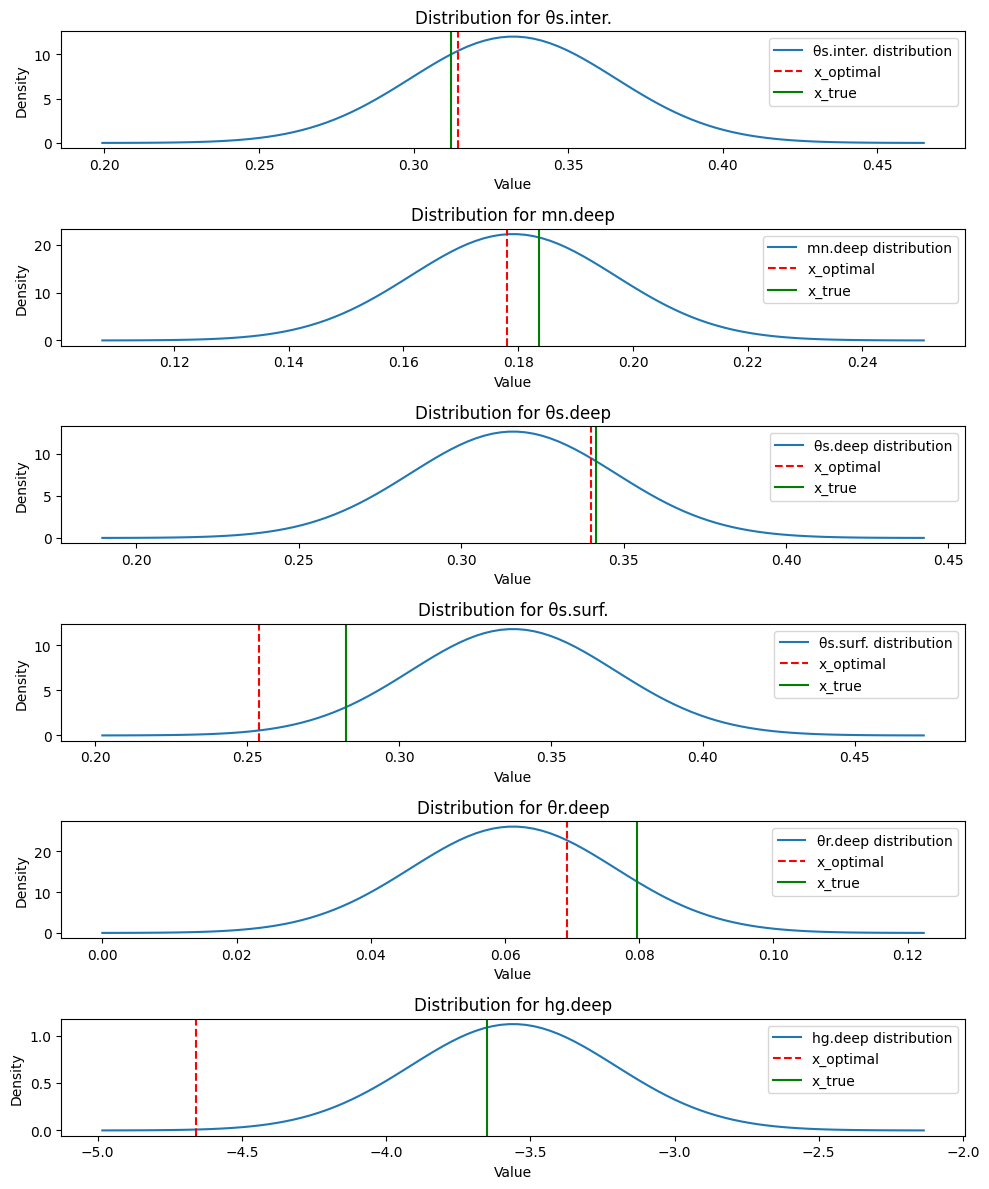

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm  
# Replace these with your actual x_true values
x_true_values = [0.312131485917921,0.183627104095568,0.341646050842506,0.282666344420186,0.0796466153304157,-3.65000481082266]  


# x_optimal values you provided earlier
x_optimal = [0.3144762533239148, 0.1781081221707139, 0.3400481055701805, 0.2538438250878176, 0.0693049021931931, -4.66012270099574] 

# Replace these with the actual distributions for each parameter
param_distributions = [
    ('θs.inter.', 0.3322, 0.03322**2),
    ('mn.deep', 0.1791, 0.0179**2),
    ('θs.deep', 0.316, 0.0316**2),
    ('θs.surf.', 0.3375, 0.0338**2),
    ('θr.deep', 0.0612, 0.0153**2),
    ('hg.deep',-3.560000, 0.35600000**2)
]

# Plotting the distributions with the x_optimal and x_true values
fig, axes = plt.subplots(nrows=len(param_distributions), ncols=1, figsize=(10, 2* len(param_distributions)))

for ax, (name, mu, sigma2), x_opt, x_tru in zip(axes, param_distributions, x_optimal, x_true_values):
    # Plot the distribution
    sigma = np.sqrt(sigma2)  # Convert variance to standard deviation
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    y = norm.pdf(x, mu, sigma)
    ax.plot(x, y, label=f'{name} distribution')
    
    # Plot the x_optimal and x_true values
    ax.axvline(x=x_opt, color='red', linestyle='--', label='x_optimal')
    ax.axvline(x=x_tru, color='green', linestyle='-', label='x_true')
    
    # Formatting
    ax.set_title(f'Distribution for {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.show()

**EI(x), on our real calibration problem on one signle rain Z_1** 

In [112]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from skopt import gp_minimize
from skopt.space import Real
import matplotlib.pyplot as plt
import warnings
import csv 
import os  
warnings.filterwarnings("ignore", message="X does not have valid feature names", category=UserWarning)

# Load the provided data files
x_train_path = '/home/tomari/Documents/First_simulation/x_train.csv'
x_true_path = '/home/tomari/Documents/First_simulation/x_true.csv'
y_obs_path = '/home/tomari/Documents/First_simulation/y_obs.csv'
y_train_path = '/home/tomari/Documents/First_simulation/y_train.csv'

# Load the data from the provided CSV files
x_train_df = pd.read_csv(x_train_path)
y_train_df = pd.read_csv(y_train_path)
y_obs_df = pd.read_csv(y_obs_path)

# Convert DataFrames to numpy arrays
y_train = y_train_df.values

y_obs = y_obs_df.values 

x_train = x_train_df.values

#Conversion of x_train to a list 

x_train_list_old = x_train.tolist() 

# Assuming x_train is a NumPy array with shape (50, 6)
x_train_list = x_train.tolist()

# Reshape y_train_array to separate each rain block
y_train_reshaped = y_train.reshape(198, len(x_train), 25)

# Compute MSE for each block

def cost(y_train_reshaped):
   # Initialize an array to store the MSE for each block
   global_costs_on_rains = np.zeros((198, 50))
   for i in range(198):
    for j in range(50):
        # Select the block
        y_rain = y_train_reshaped[i]  # First block of y_train (50x25)
     
        # Compute the MSE between the block and the corresponding observation
        F = ((y_rain[j] - y_obs[i])**2).mean()
        
        # Store the MSE in the appropriate index of the global_costs_on_rains array
        global_costs_on_rains[i, j] = F
        
   return global_costs_on_rains

# the evaluations of the cost function on 50 parameter set 
f_values = cost(y_train_reshaped)

# the evaluation of the cost function on the first rain z_1 

f_values_z1 = f_values[0]

#Conversion to a list 

f_values_z1_list = f_values_z1.tolist() 

def f_2(x):
  return x[0]**2

#print(f_values_z1_list)

# Initialize the Gaussian Process model (Optionnal)

# Defining Kernel 
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=2.5)

# Optimizing the gaussian process with the MLE Estimation 

gp_bo_z1 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)

# Fit the model
gp_bo_z1.fit(x_train,f_values[0])

#Bayesian Optimisation using EI

# defining our search space 

parameter_names = x_train_clean.columns.tolist() # lisiting the paramters names in our data frame 

space = [Real(x_train_clean[col].min(), x_train_clean[col].max(), name=col) for col in parameter_names] # defining the search space for each paramters based on boundaries 

# Optimisation process 
results_EI_z1 = gp_minimize(f_2,
                      space, 
                      n_calls = 1,
                      x0=x_train_list,
                      y0=f_values_z1_list,
                      n_initial_points=0,
                      acq_func = 'EI',
                      random_state=1234) 
x_new = results_EI_z1.x_iters[-1]

print("x_n+1 = Argmax EI(x) = ", x_new)

# Paramter names 

paramter_names = ["thetas_9","mn_10", "thetas_10", "thetas_13","thetar_10","hg_10"]

# Append x_new to x_train

x_new_reshaped = [x_new]

#
x_new_df= pd.DataFrame(x_new_reshaped, columns = paramter_names)

# Concatenate x_train_df and x_new_df
x_train_df = pd.concat([x_train_df, x_new_df], ignore_index=True)

#print(x_train_df)
# Specify the file name

xnew_csv = 'x_new.csv'

# for x_train 
xtrain_csv = 'x_train.csv'

# Specify the directory path
directory = '/home/tomari/Documents/First_simulation'

# Specify the file name
xnew_csv = os.path.join(directory, 'x_new.csv')

output_csv_path = '/home/tomari/Documents/First_simulation/x_train.csv'

# Save the DataFrame as a CSV file
x_train_df.to_csv(output_csv_path, index=False)


# Write the list of float values to a CSV file
with open(xnew_csv, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['', 'x'])
    for paramter_names, value in zip(paramter_names, x_new):
        writer.writerow([paramter_names,value])

#print(results_EI_z1) 
print(f"CSV file '{xnew_csv}' has been created successfully.")
print("DataFrame saved as CSV file:", output_csv_path)


ValueError: cannot reshape array of size 247550 into shape (198,50,25)

Valeurs de x: [[ 2]
 [-5]
 [-3]
 [ 4]]
Valeurs de f(x) = x^2: [[ 4]
 [25]
 [ 9]
 [16]]


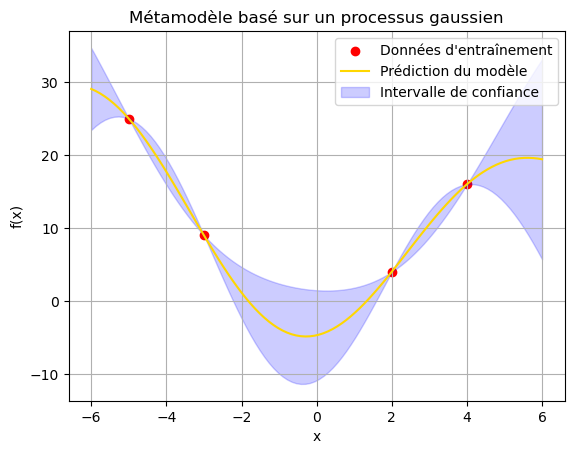

In [87]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names", category=UserWarning)
# Définir les valeurs de x pour lesquelles vous souhaitez évaluer la fonction
x_values = np.array([2, -5, -3, 4]).reshape(-1,1)

# Calculer les valeurs de la fonction f(x) = x^2 pour chaque valeur de x
f_values = x_values ** 2

# Afficher les valeurs calculées
print("Valeurs de x:", x_values)
print("Valeurs de f(x) = x^2:", f_values)

# Initialiser le modèle de processus gaussien avec un noyau RBF
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Entraîner le modèle sur les données d'entraînement
gp.fit(x_values, f_values)

# Prédire les valeurs de y pour de nouvelles valeurs de x

x_new = np.linspace(-6, 6, 100).reshape(-1, 1)  # Nouvelles valeurs de x pour la prédiction
y_pred, sigma = gp.predict(x_new, return_std=True)

# Plot des données d'entraînement
plt.scatter(x_values, f_values, color='red', label='Données d\'entraînement')

# Plot de la prédiction du modèle
plt.plot(x_new, y_pred, color='gold', label='Prédiction du modèle')

# Plot de l'intervalle de confiance (écart-type)
plt.fill_between(x_new.flatten(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='blue', alpha=0.2, label='Intervalle de confiance')

# Personnalisation du graphique
plt.title('Métamodèle basé sur un processus gaussien')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()


/home/tomari/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[1.13615662]


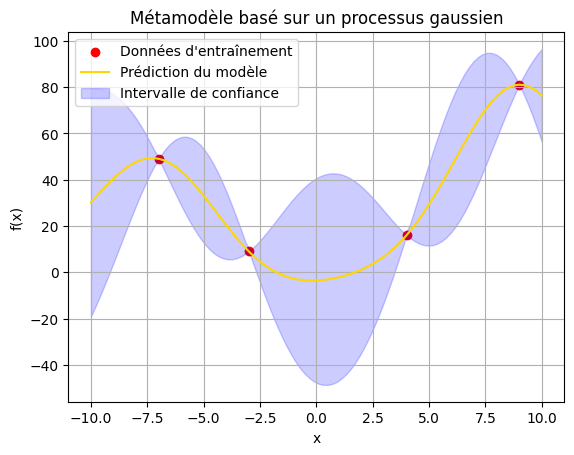

In [318]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt

#Search space 

S = [(-10,10)]
x_values = np.array([4, -7, -3, 9]).reshape(-1,1)

# Calculer les valeurs de la fonction f(x) = x^2 pour chaque valeur de x
f_values = x_values ** 2

# Initialiser le modèle de processus gaussien avec un noyau RBF

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Entraîner le modèle sur les données d'entraînement
gp.fit(x_values, f_values)

#predictions 

print(gp.predict([[2]]))


# Prédire les valeurs de y pour de nouvelles valeurs de x

x_new = np.linspace(-10, 10, 100).reshape(-1, 1)  # Nouvelles valeurs de x pour la prédiction
y_pred, sigma = gp.predict(x_new, return_std=True)

# Plot des données d'entraînement
plt.scatter(x_values, f_values, color='red', label='Données d\'entraînement')

# Plot de la prédiction du modèle
plt.plot(x_new, y_pred, color='gold', label='Prédiction du modèle')

# Plot de l'intervalle de confiance (écart-type)
plt.fill_between(x_new.flatten(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='blue', alpha=0.2, label='Intervalle de confiance')

# Personnalisation du graphique
plt.title('Métamodèle basé sur un processus gaussien')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()


In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
import matplotlib.pyplot as plt
from scipy.stats import norm
from skopt import gp_minimize
from skopt.space import Real

# Define the search space
space = [Real(-10, 10)] # Example: Search space from -10 to 10

# Initial evaluation points
x_values_1D = [[-7], [-3], [1], [9]]#.reshape(-1, 1)
# Initial function evaluations
f_values_1D = [(x[0]) **2 for x in x_values_1D]

# Initialize the Gaussian Process Regressor with an RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=2.5)
gp_1D = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_1D.fit(x_values_1D, f_values_1D)
# Define the Expected Improvement acquisition function
def expected_improvement(x, surrogate_model, current_best, epsilon=1e-6):
    
    mean, std = gp_1D.predict(np.array(x).reshape(-1, 1), return_std=True)
    std = np.maximum(std, epsilon)  # Avoid division by zero
    z = (current_best - mean) / std
    ei = (current_best - mean) * norm.cdf(z) + std * norm.pdf(z)
    return ei

# Define the objective function to minimize (negative of expected improvement)
def objective_function(x):
    return - expected_improvement(x, gp_1D, np.min(f_values_1D))[0]

# Perform Bayesian optimization
res_1d= gp_minimize(objective_function, space,
                    n_calls=10,   
                    x0=x_values_1D,       # Specify initial points
                    #y0=f_values_1D,
                    n_initial_points=0,
                    random_state=1234)

print("Next point to evaluate:", res_1d.x)
print (res_1d)

/home/tomari/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[-7]
[-3]
[1]
[9]
[-0.04672667054701307]
[-0.13534466931919553]
[-0.1632661494323422]
[-0.6913287638602146]
[-10.0]
[-0.7580425643161188]
Next point to evaluate: [-0.7580425643161188]
          fun: -5.563317054005537
            x: [-0.7580425643161188]
    func_vals: [-0.000e+00 -0.000e+00 -3.990e-06 -0.000e+00 -4.617e+00
                -4.841e+00 -4.905e+00 -5.559e+00 -9.992e-01 -5.563e+00]
      x_iters: [[-7], [-3], [1], [9], [-0.04672667054701307], [-0.13534466931919553], [-0.1632661494323422], [-0.6913287638602146], [-10.0], [-0.7580425643161188]]
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                                        n_restarts_optimizer=2, noise='gaussian',
                                        normalize_y=True, random_state=822569775), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                                        n_restarts_optimi

In [49]:
#gp.predict([[-0.04672667054701307]])
import numpy as np

# Generate multiple samples
samples = np.random.randn(10000)

# Calculate mean and standard deviation
mean = np.mean(samples)
std_dev = np.std(samples)

print("Mean:", mean)
print("Standard Deviation:", std_dev)


Mean: -0.004549367971537481
Standard Deviation: 0.9939155512185286


**How the EI is functiones**

**Les EI Manuellement**

In [68]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
from scipy.stats import norm
from skopt import gp_minimize
from skopt.space import Real
np.random.seed(1234)

# Define the search space
#noise_level = 0.01

def f(x): #noise_level=noise_level):
    return x[0] ** 2 #+ np.random.randn() * noise_level

space = [(-2.0, 2.0)] # Example: Search space from -10 to 10

# Initial evaluation points
# Initial evaluation points
x_initial = [[-2],[1],[1.0859496742748616],[0.42167229754721225],[-0.07439747970218691],[0.06393657327441948],[0.009168775927585582],[-0.3242713488588911]]
# Evaluate the objective function at initial points
f_initial = [f(x) for x in x_initial]
#print(f_initial)
res_great = gp_minimize(f,                  # the function to minimize
                  space,              # the bounds on each dimension of x
                  acq_func="EI",     # the acquisition function
                  n_calls=1,         # the number of evaluations
                  x0=x_initial,       # Specify initial points
                  y0=f_initial,
                  n_initial_points=0,  # Specify initial evaluations
                  n_random_starts=0,
                  #initial_point_generator="lhs", 
                  #random_state=1234)   # the random seed
                       )    
print("The argument point of the function at the minimum", res_great.x)
print("Objective function at the minimum : ", res_great.fun) 
#print(res_great)

The argument point of the function at the minimum [0.009168775927585582]
Objective function at the minimum :  8.406645201027284e-05


**Les EI autmatomatisé avec g_minimize**

In [74]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
from scipy.stats import norm
from skopt import gp_minimize
from skopt.space import Real
np.random.seed(1234)

# Define the search space
#noise_level = 0.01

def f(x): #noise_level=noise_level):
    return x[0] ** 2 #+ np.random.randn() * noise_level

space = [(-2.0, 2.0)] # Example: Search space from -10 to 10

# Initial evaluation points
# Initial evaluation points
x_initial = [[-2],[1]]
# Evaluate the objective function at initial points
f_initial = [f(x) for x in x_initial]
#print(f_initial)
res_great = gp_minimize(f,                  # the function to minimize
                  space,              # the bounds on each dimension of x
                  acq_func="EI",     # the acquisition function
                  n_calls=1,         # the number of evaluations
                  x0=x_initial,       # Specify initial points
                  y0=f_initial,
                  n_initial_points=0,  # Specify initial evaluations
                  n_random_starts=0,
                  #initial_point_generator="lhs", 
                  #random_state=1234)   # the random seed
                       )    
print("The argument point of the function at the minimum", res_great.x)
print("Objective function at the minimum : ", res_great.fun) 
print(res_great)

The argument point of the function at the minimum [1]
Objective function at the minimum :  1.0
          fun: 1.0
            x: [1]
    func_vals: [ 4.000e+00  1.000e+00  1.179e+00]
      x_iters: [[-2], [1], [1.0859496742748616]]
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                                        n_restarts_optimizer=2, noise='gaussian',
                                        normalize_y=True, random_state=822569775), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                                        n_restarts_optimizer=2, noise='gaussian',
                                        normalize_y=True, random_state=822569775)]
        space: Space([Real(low=-2.0, high=2.0, prior='uniform', transform='normalize')])
 random_state: RandomState(MT19937)
        specs:     args:                    func: <function f at 0x7f87224949a0>
                

**Local Optimisation**

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats import norm

# Search space

S = [(-10, 10), (-10, 10)] # 2 dimensions

# Initial evaluation points
x_values = np.array([[4, 2], [-7, -3], [-3, 5], [9, 1]])

f_values = np.sum((x_values) ** 2, axis=1)
# Initialize the Gaussian Process model with an RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Train the model on the training data
gp.fit(x_values, f_values)

def expected_improvement(x, surrogate_model, current_best, epsilon=1e-6):
    """
    Calculate the Expected Improvement (EI) at point x.
    
    Parameters:
        x: Point in the search space.
        surrogate_model: Surrogate model (e.g., Gaussian process) predicting the objective function values.
        current_best: Current best observed objective function value.
        epsilon: Small value to avoid division by zero.
    
    Returns:
        Expected Improvement at point x.
        """
    x = np.atleast_2d(x)
    mean, std = surrogate_model.predict(x, return_std=True)
    std = np.maximum(std, epsilon)  # Avoid division by zero

    z = (current_best - mean) / std
    ei = (current_best - mean) * norm.cdf(z) + std * norm.pdf(z)
    return ei


# Maximize the Expected Improvement to find the next point to evaluate
next_point = maximize_expected_improvement(gp, np.min(f_values), S[0])

print("Next point to evaluate:", next_point)


Next point to evaluate: [0.18910041]


/home/tomari/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


**EGO**

In [324]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from scipy.stats import norm
from skopt import gp_minimize
from skopt.space import Real, Space

# Search space
space = Space([Real(-10, 10), Real(-10, 10)])  # 2 dimensions

# Initial evaluation points
x_values = np.array([[4, 2], [-7, -3], [-3, 5], [9, 1]])  # 4 points in 2D

# Initial evaluations
f_values = np.sum(x_values**2, axis=1)  # Sum of squares of elements in each row

# Initialize the Gaussian Process model with a Matern kernel
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Train the model on the training data

def expected_improvement(x, surrogate_model, current_best, epsilon=1e-6):
    gp.fit(x_values, f_values)
    x = np.array(x).reshape(1, -1)
    mean, std = surrogate_model.predict(x, return_std=True)
    std = np.maximum(std, epsilon)
    
    z = (current_best - mean) / std
    ei = (current_best - mean) * norm.cdf(z) + std * norm.pdf(z)
    return ei[0]

def objective_function(x):
    print(x)
    return -expected_improvement(x, gp, np.min(f_values))

# Run Bayesian optimization to find the next point to evaluate
res = gp_minimize(objective_function, space, n_calls=10, random_state=123)

print("Next point to evaluate:", res.x)

[4.259106410464547, -1.4305814762634839]
[3.817697100537236, 4.383006203095462]
[-0.17762133134805325, 5.600555238241586]
[-1.78151254581962, 1.5938859404522034]
[-7.200984747392309, -1.9796488667759267]


/home/tomari/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/tomari/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/tomari/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/toma

[2.546340186752335, -3.5169821324091775]
[-5.1048144609216015, 3.895103543705382]
[1.8780479934804752, 2.63584035374101]
[-1.1948564387184728, -8.325470308728313]


/home/tomari/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/tomari/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/tomari/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/toma

[4.246603627775251, -1.442730183243608]
Next point to evaluate: [-1.1948564387184728, -8.325470308728313]


In [137]:
from skopt import gp_minimize
from skopt.space import Real, Space

def f(x):
    return x[0]**2 + x[1]**2 # Example objective function

initial_points = [[4, 2], [-7, -3], [-3, 5], [9, 1]]  # Specify initial points
initial_evaluations = np.sum(np.array(initial_points) ** 2, axis=1)

res = gp_minimize(f,                  # the function to minimize
                  [Real(-10, 10),Real(-10,10)],        # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f
                  n_random_starts=0,  # Make optimization deterministic
                  x0=initial_points,  # Specify initial points
                  y0=initial_evaluations,  # Specify initial evaluations
                  random_state=123)  # the random seed
print(res.x)


[0.0037663294895047272, 0.005705411890730261]


In [563]:
x_values = np.array([[4, 2], [-7, -3], [-3, 5], [9, 1],[4.90675175,5.15550612],[0.37580887,0.46585219],[-1.4145784,1.99615098],[ 1.4109167,-0.98758885],[1.47374397,1.45084681],[0.05912575,0.44851181],[ 0.3001921,-0.37675037]
,[0.22724459,0.39955403], [0.1545853,1.13457326],[0.59498796,0.23983627],[0.40092915,0.478509],[-0.21653863,-0.01592028],[0.22984776,0.16144175],[-0.47667124,-0.82961532]
                    ,[-0.21533006,-0.15688462],[0.35859633,-0.48344402],[0.06545141,-0.50275499],[0.55202411,0.37320063],[0.16829947,-0.52178239],[-0.51916468,0.44568423],
[-0.5000951,-0.04288331],[0.22465725,0.0436782],[0.33055751,-0.89854429],[-0.35602434,0.04277199],[-1.02818634,0.23449714],[-0.16538824,-0.05667531]
                    , [-0.31208789, 0.00353473],[-0.1832642,0.10407135]]) 
 #Initial evaluations
f_values = np.sum((x_values) ** 2, axis=1)  # Somme des carrés des éléments de chaque ligne

#best current piint 

x0_index = np.argmin(f_values)
x0 = x_values[x0_index]
print(x0)
print(np.min(f_values))

[-0.16538824 -0.05667531]
0.0305653606938937


In [138]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from scipy.stats import norm
from skopt import gp_minimize
from skopt.space import Real, Space
from scipy.optimize import differential_evolution
# Définition de la fonction à minimiser
def f(x):
    return (x)[0]**2 + (x)[1]**2  # Fonction à minimiser

# Search space
bounds = [(-4, 4), (-4, 4)] # 2 dimensions

# Initial evaluation points
x_values = np.array([[4, 2], [-7, -3], [-3, 5], [9, 1]])  # 4 points en 2D

# Initial evaluations
f_values = np.sum((x_values) ** 2, axis=1)  # Somme des carrés des éléments de chaque ligne

#best current piint 

x0_index = np.argmin(f_values)
x0 = x_values[x0_index]


# Initialize the Gaussian Process model with an RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Train the model on the training data

def ei(x):
 x = np.atleast_2d(x)
 mean, std = gp.predict(x, return_std=True)
 z = (mean - mean.min()) / std
 return -(mean - std * norm.pdf(z) / norm.cdf(z))

result = differential_evolution(func=ei, bounds=bounds, strategy='best1bin', maxiter=1000, popsize=100)
print(result.x)

[3.91155316 1.72920539]


**Code avec les EI embouclé**

Coût très élevé 

In [314]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C

def f(x):
    return np.sum(np.array(x) ** 2)

# Initialize the Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

x_values = np.array([[4, 2], [-7, -3], [-3, 5], [9, 1]])
f_values = np.array([f(x) for x in x_values])

def expected_improvement(x, gp, xi=0.01):
    x = np.array(x).reshape(1, -1)
    mu, sigma = gp.predict(x, return_std=True)
    mu_sample = gp.predict(x_values)
    sigma = np.maximum(sigma, 1e-6)
    mu_sample_opt = np.min(mu_sample)
    imp = mu_sample_opt - mu - xi
    z = imp / sigma
    ei = imp * norm.cdf(z) + sigma * norm.pdf(z)
    return ei[0] if sigma > 0 else 0.0

def propose_location(acquisition, gp, bounds, n_restarts=25):
    dim = bounds.shape[0]
    min_val = float("inf")
    min_x = None

    def min_obj(X):
        return -acquisition(X, gp)

    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=tuple(map(tuple, bounds)), method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x

    return min_x.reshape(-1, 1)

max_points = 10
bounds = np.array([[-10, 10], [-10, 10]])

while len(x_values) < max_points + 4:
    gp.fit(x_values, f_values)
    x_next = propose_location(expected_improvement, gp, bounds)
    f_next = f(x_next.ravel())
    
    x_values = np.vstack((x_values, x_next.T))
    f_values = np.append(f_values, f_next)

    print("Next point to evaluate:", x_next.T)
    print("Objective function value at next point:", f_next)

min_index = np.argmin(f_values)
print("Minimum of f found at:", x_values[min_index], "with value:", f_values[min_index])


/home/tomari/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Next point to evaluate: [[  3.75204983 -10.        ]]
Objective function value at next point: 114.07787792570325


/home/tomari/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Next point to evaluate: [[ 3.73108085 10.        ]]
Objective function value at next point: 113.92096428962346


/home/tomari/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Next point to evaluate: [[-10.  10.]]
Objective function value at next point: 200.0


/home/tomari/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Next point to evaluate: [[0.6507976  1.45489304]]
Objective function value at next point: 2.5402512632854966


/home/tomari/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Next point to evaluate: [[-10. -10.]]
Objective function value at next point: 200.0


/home/tomari/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Next point to evaluate: [[-1.98126965  0.84334953]]
Objective function value at next point: 4.636667870624706


/home/tomari/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Next point to evaluate: [[-0.68908906  2.14802425]]
Objective function value at next point: 5.088851900937126


/home/tomari/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Next point to evaluate: [[0.23596815 0.06710941]]
Objective function value at next point: 0.06018464105909089


/home/tomari/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Next point to evaluate: [[ 1.75363304 -0.15635553]]
Objective function value at next point: 3.0996759015807385


/home/tomari/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Next point to evaluate: [[-0.7901731  -1.21481186]]
Objective function value at next point: 2.1001413901764536
Minimum of f found at: [0.23596815 0.06710941] with value: 0.06018464105909089
